In [1]:
!pip install boto3
import boto3
import os
from PIL import Image
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.1 MB/s eta 0:00:00


In [2]:
import boto3
import os

# Set your AWS credentials as environment variables
os.environ['AWS_ACCESS_KEY_ID'] = '******'
os.environ['AWS_SECRET_ACCESS_KEY'] = '*******'
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

# Initialize a session using the environment variables
session = boto3.Session(
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
    region_name=os.environ['AWS_DEFAULT_REGION']
)

# Create an S3 client
s3 = session.client('s3')
# Specify the bucket name and prefix
bucket_name = 'lntav'
prefix = 'road sign/motor_allowed/'


In [3]:

# List objects within the specified bucket and prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get('Contents', []):
    print(obj['Key'])

road sign/motor_allowed/028_0001.png
road sign/motor_allowed/028_0002.png
road sign/motor_allowed/028_0003.png
road sign/motor_allowed/028_0004.png
road sign/motor_allowed/028_0005.png
road sign/motor_allowed/028_0006.png
road sign/motor_allowed/028_0007.png
road sign/motor_allowed/028_0008.png
road sign/motor_allowed/028_0009.png
road sign/motor_allowed/028_0010.png
road sign/motor_allowed/028_0011.png
road sign/motor_allowed/028_0012.png
road sign/motor_allowed/028_0013.png
road sign/motor_allowed/028_0014.png
road sign/motor_allowed/028_0015.png
road sign/motor_allowed/028_0016.png
road sign/motor_allowed/028_0017.png
road sign/motor_allowed/028_0018.png
road sign/motor_allowed/028_0019.png
road sign/motor_allowed/028_0020.png
road sign/motor_allowed/028_0021.png
road sign/motor_allowed/028_0022.png
road sign/motor_allowed/028_0023.png
road sign/motor_allowed/028_0024.png
road sign/motor_allowed/028_0025.png
road sign/motor_allowed/028_0026.png
road sign/motor_allowed/028_0027.png
r

In [4]:
# Specify the local directory where the file will be downloaded
local_dir = '/content/'

# Specify the file name you want to download
file_name = 'road sign/motor_allowed/028_1_0180.png'
local_path = os.path.join(local_dir, file_name.split('/')[-1])

# Download the file
try:
    s3.download_file(bucket_name, file_name, local_path)
    print(f"Downloaded {file_name} to {local_path}")
except Exception as e:
    print(f"Error: {e}")


Downloaded road sign/motor_allowed/028_1_0180.png to /content/028_1_0180.png


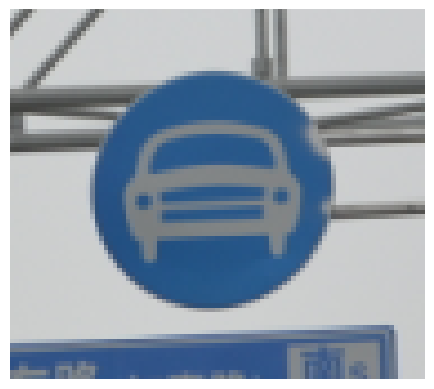

In [5]:
# Load and display the image
try:
    img = Image.open(local_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError as e:
    print(f"File not found: {e}")


In [6]:
!pip install tensorflow


In [8]:
!pip install boto3
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install pillow


In [9]:
import boto3
import os
from PIL import Image
from io import BytesIO

# Initialize the S3 client
s3 = boto3.client('s3')

# Your S3 bucket details
bucket_name = 'lntav'
folder_name = 'road sign/'

def download_images_from_s3(bucket_name, folder_name):
    # List objects within the specified folder
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
    images = []
    labels = []

    # Iterate through the files in the folder
    for obj in response.get('Contents', []):
        key = obj['Key']
        if key.endswith('.jpg') or key.endswith('.png'):  # Check for image files
            # Download the image
            img_obj = s3.get_object(Bucket=bucket_name, Key=key)
            img_data = img_obj['Body'].read()
            image = Image.open(BytesIO(img_data))
            images.append(image)

            # Extract label from the key (assuming folder structure represents labels)
            label = key.split('/')[-2]
            labels.append(label)

    return images, labels

# Download images and labels
images, labels = download_images_from_s3(bucket_name, folder_name)


In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Resize images and convert to numpy arrays
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = img.resize((224, 224))  # Resize images to 224x224
        img_array = img_to_array(img)
        processed_images.append(img_array)
    return np.array(processed_images)

# Preprocess images
processed_images = preprocess_images(images)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(processed_images, one_hot_labels, test_size=0.2, random_state=42)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build a simple CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.2493 - loss: 133.0586 - val_accuracy: 0.5750 - val_loss: 1.5925
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4344 - loss: 1.6850 - val_accuracy: 0.7500 - val_loss: 0.7184
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.7695 - loss: 0.6659 - val_accuracy: 0.8850 - val_loss: 0.3311
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8704 - loss: 0.3997 - val_accuracy: 0.9250 - val_loss: 0.2651
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.8875 - loss: 0.3120 - val_accuracy: 0.9700 - val_loss: 0.1507
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9296 - loss: 0.1950 - val_accuracy: 0.9700 - val_loss: 0.1047
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9393 - loss: 0.1513 - val_accuracy: 0.9750 - val_loss: 0.1076
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9600 - loss: 0.1345 - val_accuracy: 0.9800 - 

In [13]:
# Save the model to S3
model_save_path = '/tmp/road_sign_model.h5'
model.save(model_save_path)

s3.upload_file(model_save_path, bucket_name, 'models/road_sign_model.h5')


In [14]:
pip install s3fs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.155
    Uninstalling botocore-1.34.155:
      Successfully uninstalled botocore-1.34.155
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.34.155 requires botocore<1.35.0,>=1.34.155, but you have botocore 1.34.131 which is incompatible.


In [15]:
import tensorflow as tf
import s3fs

# Initialize the S3 file system
s3 = s3fs.S3FileSystem()

# Define the S3 path to your model
s3_path = 's3://your-bucket-name/models/road_sign_model.h5'

# Load the model directly from S3
with s3.open(s3_path, 'rb') as model_file:
    model = tf.keras.models.load_model(model_file)

print('Model loaded successfully from S3')


PermissionError: Forbidden

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# Load the model
model_path = '/content/road_sign_model.h5'
model = tf.keras.models.load_model(model_path)
print('Model loaded successfully')

# Function to preprocess the uploaded image
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to the model input size
    img_array = np.array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Function to handle the uploaded image
def on_upload_change(change):
    uploaded_file = change['new']
    for name, file in uploaded_file.items():
        img = Image.open(io.BytesIO(file['content']))  # Open the image
        img_array = preprocess_image(img)  # Preprocess the image

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        print(f'Predicted class: {predicted_class}')

# Create an upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Accept image files
    multiple=False  # Only allow single file upload
)
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)


Model loaded successfully


FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class: [9]


In [18]:
import boto3

# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# Define the bucket name
bucket_name = 'lntav'

def count_images_in_s3(bucket_name):
    # Initialize the S3 resource
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)

    # Initialize the count
    image_count = 0

    # List objects in the bucket
    for obj in bucket.objects.all():
        # Check if the object is an image (e.g., with common image extensions)
        if obj.key.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            image_count += 1

    return image_count

# Get the total number of images
total_images = count_images_in_s3(bucket_name)
print(f'Total number of images in bucket "{bucket_name}": {total_images}')


Total number of images in bucket "lntav": 3928


In [19]:
import boto3

# Initialize the S3 client
s3 = boto3.client('s3')

# Define the bucket name and prefix (directory)
bucket_name = 'lntav'
prefix = 'road sign/'

def count_images_in_s3(bucket_name, prefix):
    # Initialize the count
    image_count = 0

    # List objects with the specified prefix
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        # Check if 'Contents' is in the page to avoid KeyError
        if 'Contents' in page:
            for obj in page['Contents']:
                # Check if the object is an image (e.g., with common image extensions)
                if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    image_count += 1

    return image_count

# Get the total number of images
total_images = count_images_in_s3(bucket_name, prefix)
print(f'Total number of images in "{prefix}" of bucket "{bucket_name}": {total_images}')


Total number of images in "road sign/" of bucket "lntav": 3928
